In [13]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
import numpy as np
import pandas as pd

In [15]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report's Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [16]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['optimizer'] = cv_results['param_optimizer']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 
                         'train_accuracy', 'test_accuracy', 
                         'nr_train_sv', 'nr_test_sv']] = cv_results[['param_C', 'mean_fit_time', 
                                                                     'mean_train_accuracy', 'mean_test_accuracy',
                                                                     'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
    
    filtered_cv_results['nr_train_sv'] = filtered_cv_results['nr_train_sv'].round().astype(int)
    filtered_cv_results['nr_test_sv'] = filtered_cv_results['nr_test_sv'].round().astype(int)

    return filtered_cv_results

## Hinge loss

### Primal formulation

In [17]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [18]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


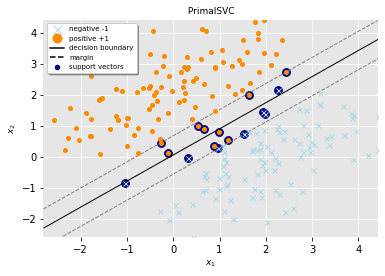

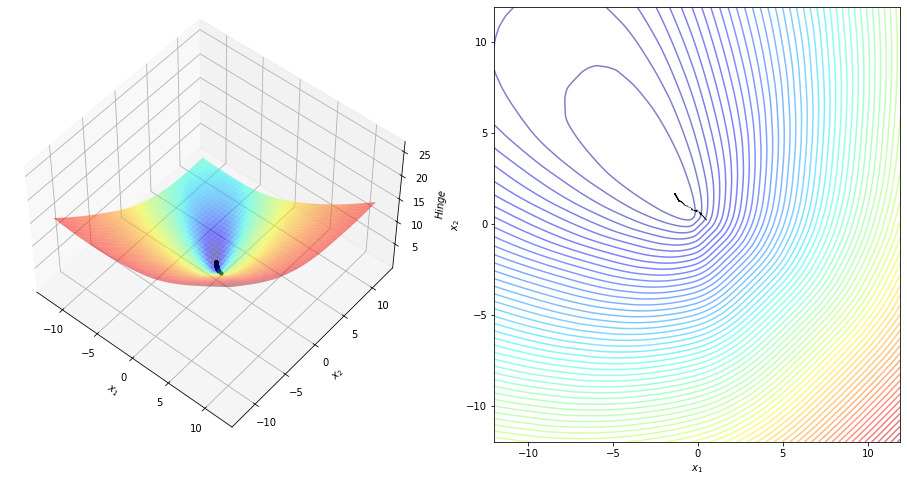

In [203]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/svc_hyperplane.png')
plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [205]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.insert(0, 'optimizer', 'custom')
custom_primal_svc_hinge_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
custom,1,0.715587,0.972487,0.969923,11,7
custom,10,0.685368,0.974975,0.969923,8,4
custom,100,0.576646,0.977481,0.969923,7,3


In [151]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [206]:
sklearn_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svc_hinge_cv_results.insert(0, 'optimizer', 'liblinear')
sklearn_primal_svc_hinge_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
liblinear,1,0.715587,0.972487,0.969923,11,7
liblinear,10,0.685368,0.974975,0.969923,8,4
liblinear,100,0.576646,0.977481,0.969923,7,3


In [207]:
overall_primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(sklearn_primal_svc_hinge_cv_results, ignore_index=True)
overall_primal_svc_hinge_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', index=False)
overall_primal_svc_hinge_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
custom,1,0.715587,0.972487,0.969923,11,7
liblinear,1,0.715587,0.972487,0.969923,11,7
custom,10,0.685368,0.974975,0.969923,8,4
liblinear,10,0.685368,0.974975,0.969923,8,4
custom,100,0.576646,0.977481,0.969923,7,3
liblinear,100,0.576646,0.977481,0.969923,7,3


### Dual formulations

In [21]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import GridSearchCV

In [22]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(svc.support_)}

#### Wolfe Dual

##### Linear

In [208]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [209]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
smo,1,0.071781,0.990012,0.990050,12,12
cvxopt,1,0.046403,0.990012,0.990050,12,12
smo,10,0.085767,0.992519,0.980100,7,7
cvxopt,10,0.025000,0.992519,0.980100,7,7
smo,100,0.121755,0.992519,0.980100,6,6
cvxopt,100,0.020040,0.992519,0.980100,6,6


In [210]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVC(kernel='linear'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [211]:
sklinear_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_linear_dual_svc_cv_results.insert(0, 'optimizer', 'libsvm')
sklinear_linear_dual_svc_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
libsvm,1,0.004200,0.990012,0.990050,26,26
libsvm,10,0.004469,0.997512,0.990050,13,13
libsvm,100,0.003470,0.997512,0.985075,10,10


In [212]:
overall_linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(sklinear_linear_dual_svc_cv_results, ignore_index=True)
overall_linear_dual_svc_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', index=False)
overall_linear_dual_svc_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
cvxopt,1,0.046403,0.990012,0.990050,12,12
libsvm,1,0.004200,0.990012,0.990050,26,26
smo,1,0.071781,0.990012,0.990050,12,12
cvxopt,10,0.025000,0.992519,0.980100,7,7
libsvm,10,0.004469,0.997512,0.990050,13,13
smo,10,0.085767,0.992519,0.980100,7,7
cvxopt,100,0.020040,0.992519,0.980100,6,6
libsvm,100,0.003470,0.997512,0.985075,10,10
smo,100,0.121755,0.992519,0.980100,6,6


##### Nonlinear

In [218]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [219]:
custom_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_nonlinear_dual_svc_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
smo,poly,1,0.446164,1.000000,0.997494,8,8
cvxopt,poly,1,0.253555,1.000000,0.994987,8,8
smo,rbf,1,0.787757,1.000000,1.000000,40,40
cvxopt,rbf,1,0.065434,1.000000,1.000000,42,42
smo,poly,10,0.274295,1.000000,0.997494,8,8
cvxopt,poly,10,0.100806,1.000000,0.994987,8,8
smo,rbf,10,0.636188,1.000000,1.000000,38,38
cvxopt,rbf,10,0.065290,1.000000,1.000000,42,42
smo,poly,100,0.304340,1.000000,0.997494,8,8
cvxopt,poly,100,0.108034,1.000000,0.994987,8,8


In [236]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(SklSVC(),
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['auto']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['auto']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [221]:
sklinear_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_nonlinear_dual_svc_cv_results.insert(0, 'optimizer', 'libsvm')
sklinear_nonlinear_dual_svc_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
libsvm,poly,1,0.003886,1.000000,0.994987,7,7
libsvm,rbf,1,0.006386,1.000000,1.000000,38,38
libsvm,poly,10,0.003939,1.000000,0.994987,7,7
libsvm,rbf,10,0.005806,1.000000,1.000000,36,36
libsvm,poly,100,0.004066,1.000000,0.994987,7,7
libsvm,rbf,100,0.005325,1.000000,1.000000,36,36


In [225]:
overall_nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(sklinear_nonlinear_dual_svc_cv_results, ignore_index=True)
overall_nonlinear_dual_svc_cv_results.sort_values(['C', 'kernel', 'optimizer'], inplace=True)
overall_nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', index=False)
overall_nonlinear_dual_svc_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
cvxopt,poly,1,0.253555,1.000000,0.994987,8,8
libsvm,poly,1,0.003886,1.000000,0.994987,7,7
smo,poly,1,0.446164,1.000000,0.997494,8,8
cvxopt,rbf,1,0.065434,1.000000,1.000000,42,42
libsvm,rbf,1,0.006386,1.000000,1.000000,38,38
smo,rbf,1,0.787757,1.000000,1.000000,40,40
cvxopt,poly,10,0.100806,1.000000,0.994987,8,8
libsvm,poly,10,0.003939,1.000000,0.994987,7,7
smo,poly,10,0.274295,1.000000,0.997494,8,8
cvxopt,rbf,10,0.065290,1.000000,1.000000,42,42


#### Lagrangian Dual

##### Linear

In [23]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [24]:
linear_qp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
qp,1,0.013105,0.967512,0.965023,129,129
qp,10,0.010758,0.967512,0.965023,129,129
qp,100,0.007632,0.967512,0.965023,129,129


In [25]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [26]:
linear_bcqp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,1,0.017351,0.982512,0.990050,130,130
bcqp,10,0.005850,0.982512,0.990050,130,130
bcqp,100,0.013462,0.982512,0.990050,130,130


In [27]:
linear_lagrangian_dual_svc_cv_results = linear_qp_lagrangian_dual_svc_cv_results.append(linear_bcqp_lagrangian_dual_svc_cv_results, ignore_index=True)
linear_lagrangian_dual_svc_cv_results.sort_values(['C', 'ld'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', index=False)
linear_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,1,0.017351,0.982512,0.990050,130,130
qp,1,0.013105,0.967512,0.965023,129,129
bcqp,10,0.005850,0.982512,0.990050,130,130
qp,10,0.010758,0.967512,0.965023,129,129
bcqp,100,0.013462,0.982512,0.990050,130,130
qp,100,0.007632,0.967512,0.965023,129,129


##### Nonlinear

In [229]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [230]:
nonlinear_qp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
qp,poly,1,0.117401,0.823787,0.738095,163,163
qp,rbf,1,1.696029,1.000000,0.997494,143,143
qp,poly,10,0.134212,0.823787,0.738095,163,163
qp,rbf,10,1.086226,0.998752,0.997494,142,142
qp,poly,100,0.048170,0.823787,0.738095,163,163
qp,rbf,100,0.941620,1.000000,0.997494,142,142


In [231]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [232]:
nonlinear_bcqp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,poly,1,3.186200,0.853759,0.728145,212,212
bcqp,rbf,1,0.044137,1.000000,1.000000,205,205
bcqp,poly,10,2.776435,0.853759,0.728145,212,212
bcqp,rbf,10,0.035251,1.000000,1.000000,205,205
bcqp,poly,100,2.888524,0.853759,0.728145,212,212
bcqp,rbf,100,0.035742,1.000000,1.000000,205,205


In [234]:
nonlinear_lagrangian_dual_svc_cv_results = nonlinear_qp_lagrangian_dual_svc_cv_results.append(nonlinear_bcqp_lagrangian_dual_svc_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['C', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', index=False)
nonlinear_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,poly,1,3.186200,0.853759,0.728145,212,212
bcqp,rbf,1,0.044137,1.000000,1.000000,205,205
qp,poly,1,0.117401,0.823787,0.738095,163,163
qp,rbf,1,1.696029,1.000000,0.997494,143,143
bcqp,poly,10,2.776435,0.853759,0.728145,212,212
bcqp,rbf,10,0.035251,1.000000,1.000000,205,205
qp,poly,10,0.134212,0.823787,0.738095,163,163
qp,rbf,10,1.086226,0.998752,0.997494,142,142
bcqp,poly,100,2.888524,0.853759,0.728145,212,212
bcqp,rbf,100,0.035742,1.000000,1.000000,205,205


## Squared Hinge loss

### Primal formulation

Fitting 3 folds for each of 3 candidates, totalling 9 fits


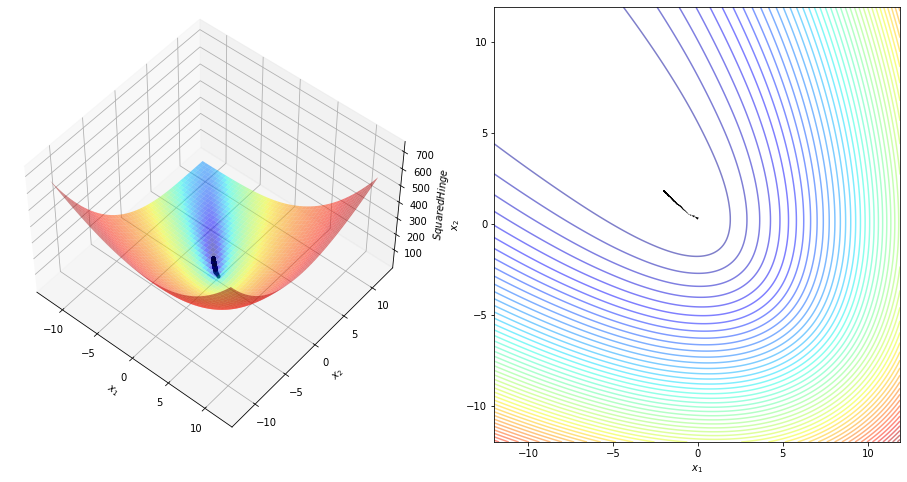

In [8]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.1),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [9]:
custom_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_squared_hinge_cv_results.insert(0, 'optimizer', 'custom')
custom_primal_svc_squared_hinge_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
custom,1,0.716020,0.987506,0.980024,10,5
custom,10,0.741283,0.987506,0.980024,4,3
custom,100,0.621490,0.987506,0.980024,1,2


In [11]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [12]:
sklearn_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svc_squared_hinge_cv_results.insert(0, 'optimizer', 'liblinear')
sklearn_primal_svc_squared_hinge_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
liblinear,1,0.004507,0.974956,0.964873,23,11
liblinear,10,0.005292,0.974956,0.959822,24,11
liblinear,100,0.005748,0.952418,0.924770,35,16
